In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy'

## Generation

In [44]:
import numpy as np
import pandas as pd

def generate_environment_df(n_samples, pe, env_id):
    I2 = np.eye(2)

    # Invariant features ~ N(0, I)
    X_inv = np.random.multivariate_normal(mean=[0, 0], cov=I2, size=n_samples)

    # Label Y = x1 + x2 + noise
    Y = X_inv.sum(axis=1) + np.random.normal(loc=0.0, scale=np.sqrt(0.1), size=n_samples)

    # Spurious features ~ N([Y, Y], pe * I)
    X_env = np.stack([Y, Y], axis=1) + np.random.multivariate_normal(mean=[0, 0], cov=pe * I2, size=n_samples)

    # Combine into DataFrame
    df = pd.DataFrame({
        "x_inv_0": X_inv[:, 0],
        "x_inv_1": X_inv[:, 1],
        "x_env_0": X_env[:, 0],
        "x_env_1": X_env[:, 1],
        "y": Y,
        "env_id": env_id,
        "pe": pe
    })

    return df

def generate_irm_dataset(n_samples_per_env=1000):
    pe_train = [0.1, 0.3, 0.5, 0.7, 0.9]
    pe_val = [0.4, 0.8]
    pe_test = [10, 100]

    # Build full DataFrames for each split
    train_df = pd.concat(
        [generate_environment_df(n_samples_per_env, pe, f"train_{i}") for i, pe in enumerate(pe_train)],
        ignore_index=True
    )
    val_df = pd.concat(
        [generate_environment_df(n_samples_per_env, pe, f"val_{i}") for i, pe in enumerate(pe_val)],
        ignore_index=True
    )
    test_df = pd.concat(
        [generate_environment_df(n_samples_per_env, pe, f"test_{i}") for i, pe in enumerate(pe_test)],
        ignore_index=True
    )

    return train_df, val_df, test_df

In [45]:
train_data, val_data, test_data = generate_irm_dataset()

In [48]:
test_data

,x_inv_0,x_inv_1,x_env_0,x_env_1,y,env_id,pe
0,-1.495982,1.043918,-1.713956,0.371034,-0.218922,test_0,10
1,0.987734,-0.599832,-2.281073,5.104915,0.083803,test_0,10
2,1.231101,-0.495051,0.347552,-0.068889,1.120209,test_0,10
3,-0.893335,-0.261544,-4.355061,-2.139011,-1.050114,test_0,10
4,1.041171,-0.945260,0.809374,-1.720440,-0.352470,test_0,10
...,...,...,...,...,...,...,...
1995,0.394048,-1.523870,-3.008849,-3.142386,-1.406397,test_1,100
1996,0.580047,0.258692,-13.286366,11.404641,1.486838,test_1,100
1997,-1.027493,-0.196807,-2.854497,3.449683,-1.132016,test_1,100
1998,-0.106350,0.148758,-4.002974,2.455903,-0.085878,test_1,100


## Visualization attempt

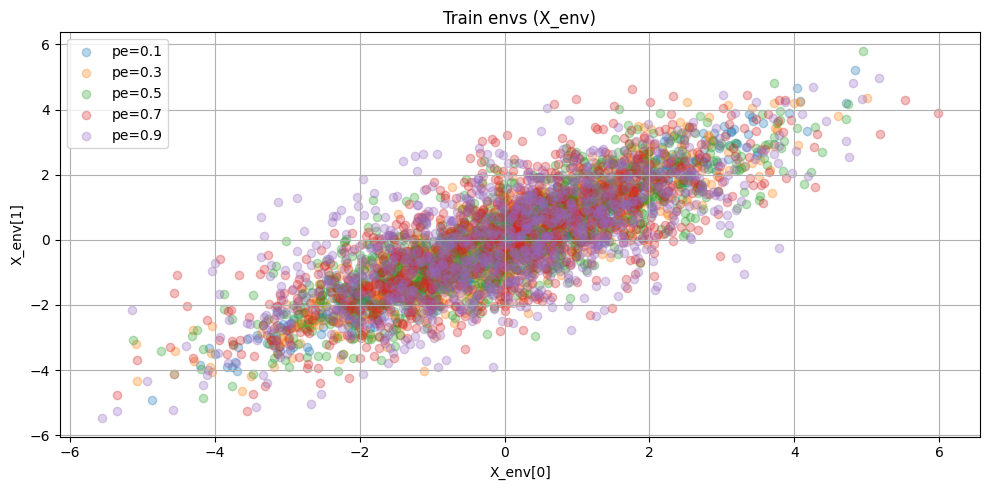

In [6]:

def plot_env_features(data, pe_values, title="X_env across environments"):
    plt.figure(figsize=(10, 5))
    for i, (X, Y) in enumerate(data):
        X_env = X[:, 2:]  # last 2 columns
        plt.scatter(X_env[:, 0], X_env[:, 1], alpha=0.3, label=f"pe={pe_values[i]}")
    plt.title(title)
    plt.xlabel("X_env[0]")
    plt.ylabel("X_env[1]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_data, val_data, test_data = generate_irm_dataset()
plot_env_features(train_data, [0.1, 0.3, 0.5, 0.7, 0.9], "Train envs (X_env)")

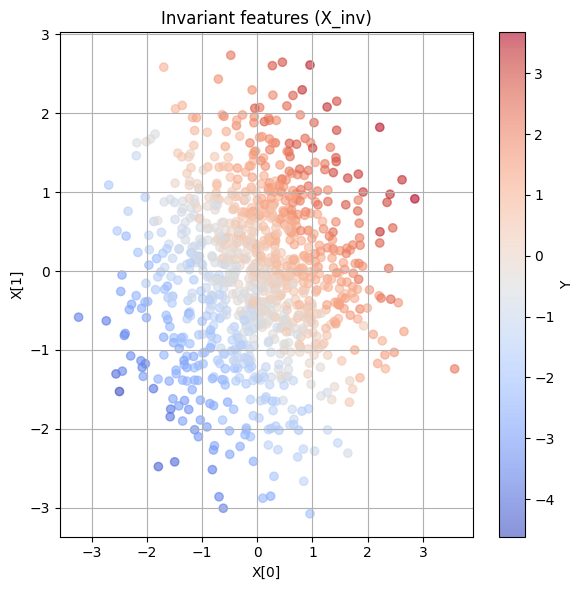

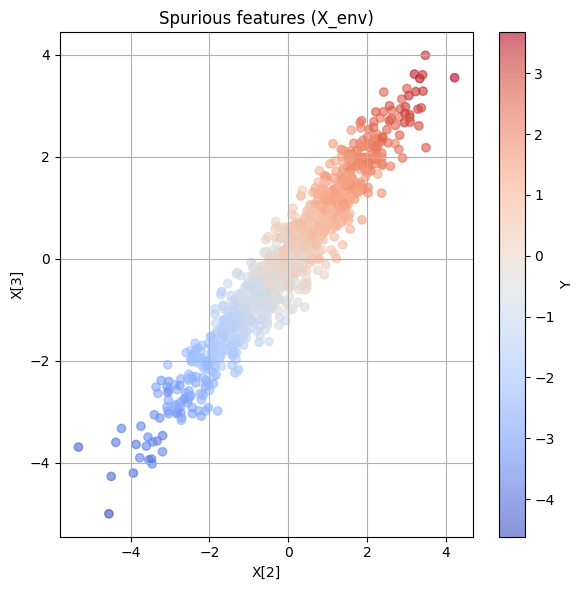

In [5]:
def plot_feature_colored_by_y(X, Y, idx1, idx2, title="Feature scatter"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, idx1], X[:, idx2], c=Y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label='Y')
    plt.xlabel(f"X[{idx1}]")
    plt.ylabel(f"X[{idx2}]")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

X, Y = train_data[0]
plot_feature_colored_by_y(X, Y, 0, 1, "Invariant features (X_inv)")
plot_feature_colored_by_y(X, Y, 2, 3, "Spurious features (X_env)")


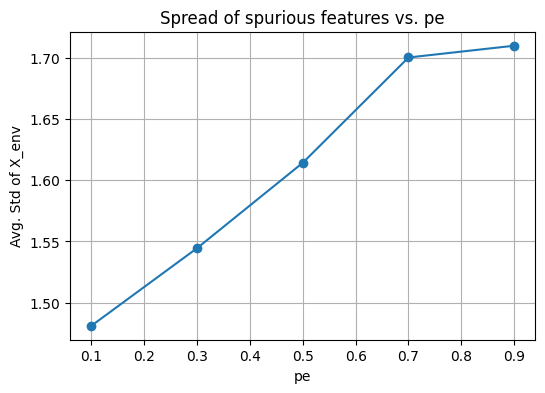

In [7]:
def plot_env_spread(data, pe_values):
    stds = [np.std(X[:, 2:], axis=0).mean() for X, _ in data]
    plt.figure(figsize=(6, 4))
    plt.plot(pe_values, stds, marker='o')
    plt.xlabel("pe")
    plt.ylabel("Avg. Std of X_env")
    plt.title("Spread of spurious features vs. pe")
    plt.grid(True)
    plt.show()

plot_env_spread(train_data, [0.1, 0.3, 0.5, 0.7, 0.9])

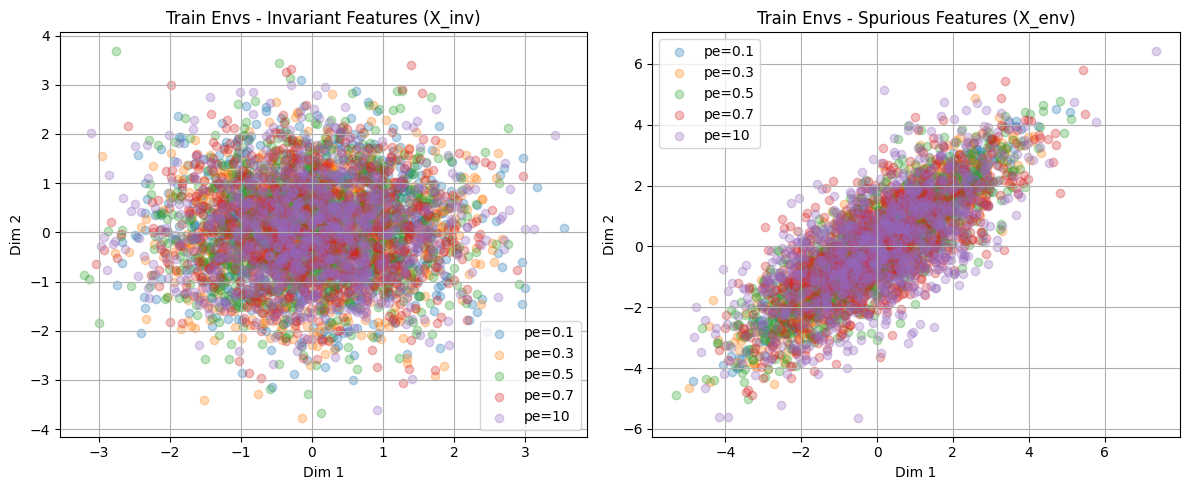

In [10]:
def plot_invariant_vs_spurious(data, pe_values, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, (X, Y) in enumerate(data):
        label = f"pe={pe_values[i]}"
        # Invariant features
        axes[0].scatter(X[:, 0], X[:, 1], alpha=0.3, label=label)
        # Spurious features
        axes[1].scatter(X[:, 2], X[:, 3], alpha=0.3, label=label)

    axes[0].set_title(title_prefix + "Invariant Features (X_inv)")
    axes[1].set_title(title_prefix + "Spurious Features (X_env)")

    for ax in axes:
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

train_data, val_data, test_data = generate_irm_dataset()
plot_invariant_vs_spurious(train_data, [0.1, 0.3, 0.5, 0.7, 10, 100], title_prefix="Train Envs - ")

In [11]:
train_data, val_data, test_data = generate_irm_dataset()
train_pe = [0.1, 0.3, 0.5, 0.7, 0.9]
test_pe = [10, 100]

In [15]:
def compare_feature_label_correlation(train_data, test_data, train_pe, test_pe):
    all_corrs = []

    def compute_corr(X, Y, pe, env_type):
        for i in range(X.shape[1]):
            corr = np.corrcoef(X[:, i], Y)[0, 1]
            all_corrs.append((i, pe, corr, env_type))

    for (X, Y), pe in zip(train_data, train_pe):
        compute_corr(X, Y, pe, 'train')

    for (X, Y), pe in zip(test_data, test_pe):
        compute_corr(X, Y, pe, 'test')

    df = pd.DataFrame(all_corrs, columns=["feature", "pe", "corr", "env_type"])
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="pe", y="corr", hue="feature", style="env_type", markers=True)
    plt.title("Correlation of Features with Y (Train vs Test)")
    plt.grid(True)
    plt.show()


C:\Users\Kos\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Kos\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


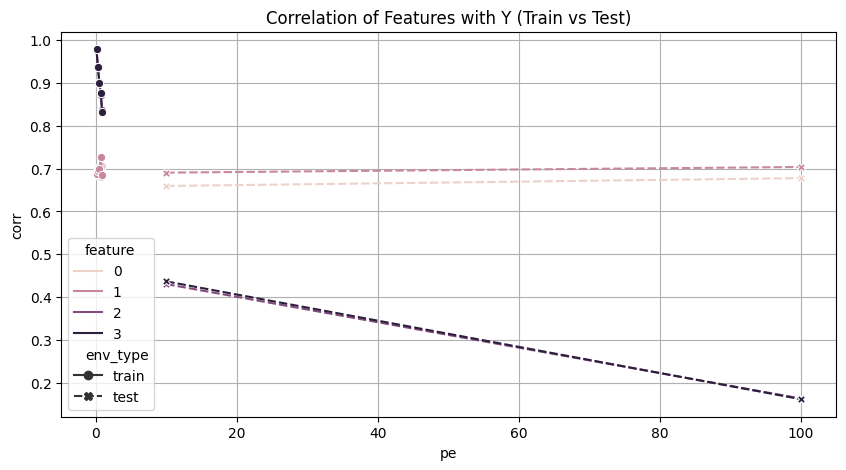

In [18]:
compare_feature_label_correlation(train_data, test_data, train_pe, test_pe)

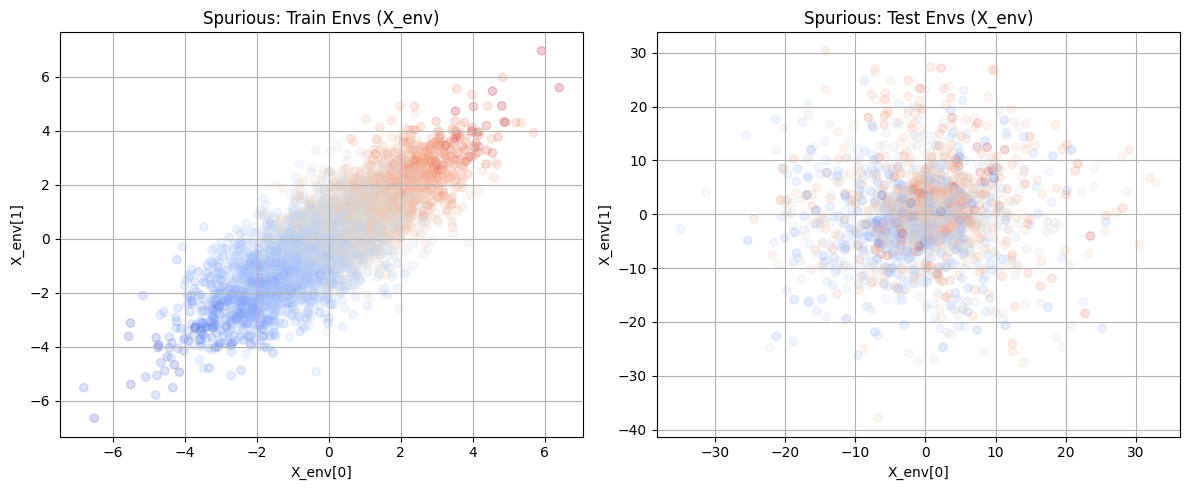

In [19]:
def compare_spurious_distributions(train_data, test_data, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for (X, Y) in train_data:
        axes[0].scatter(X[:, 2], X[:, 3], alpha=0.2, c=Y, cmap='coolwarm')

    for (X, Y) in test_data:
        axes[1].scatter(X[:, 2], X[:, 3], alpha=0.2, c=Y, cmap='coolwarm')

    axes[0].set_title(f"{title_prefix}Train Envs (X_env)")
    axes[1].set_title(f"{title_prefix}Test Envs (X_env)")
    for ax in axes:
        ax.set_xlabel("X_env[0]")
        ax.set_ylabel("X_env[1]")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

compare_spurious_distributions(train_data, test_data, title_prefix="Spurious: ")

## Baseline train

In [58]:
from sklearn.linear_model import LinearRegression

def train_linear_model(df, feature_cols):
    X = df[feature_cols].values
    y = df["y"].values

    model = LinearRegression()
    model.fit(X, y)

    return model

In [66]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, df, feature_cols):
    X = df[feature_cols].values
    y_true = df["y"].values
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    return mse

def compare_val_test_mse(model, val_df, test_df, feature_cols):
    val_mse = evaluate_model(model, val_df, feature_cols)
    test_mse = evaluate_model(model, test_df, feature_cols)
    ratio = test_mse / val_mse
    return {
        "val_mse": val_mse,
        "test_mse": test_mse,
        "test2val": ratio
    }

In [65]:
# Feature set
feature_cols = ["x_inv_0", "x_inv_1", "x_env_0", "x_env_1"]

# Generate data
train_df, val_df, test_df = generate_irm_dataset()

# Train
model = train_linear_model(train_df, feature_cols)

# Evaluate
metrics = compare_val_test_mse(model, val_df, test_df, feature_cols)

# Print results
print("Val MSE:", metrics["val_mse"])
print("Test MSE:", metrics["test_mse"])
print("Test/Val MSE Ratio:", metrics["test2val"])

Val MSE: 0.07518121932932909
Test MSE: 2.219431858722099
Test/Val MSE Ratio: 29.52109421104151


## Improvement ideas

### Test Env Leak

In [93]:
def generate_irm_dataset_with_leak(n_samples_per_env=1000, leak_fraction=0.1):
    pe_train = [0.1, 0.3, 0.5, 0.7, 0.9]
    pe_val = [0.4, 0.8]
    pe_test = [10, 100]

    # Generate base datasets
    train_df = pd.concat(
        [generate_environment_df(n_samples_per_env, pe, f"train_{i}") for i, pe in enumerate(pe_train)],
        ignore_index=True
    )
    val_df = pd.concat(
        [generate_environment_df(n_samples_per_env, pe, f"val_{i}") for i, pe in enumerate(pe_val)],
        ignore_index=True
    )
    test_df = pd.concat(
        [generate_environment_df(n_samples_per_env, pe, f"test_{i}") for i, pe in enumerate(pe_test)],
        ignore_index=True
    )
    
    # Leak test data into training set
    leaked_samples = []
    for pe in pe_test:
        # Get all samples from this test environment
        test_env_df = test_df[test_df["pe"] == pe].copy()
        
        # Sample fraction to leak
        n_leak = int(len(test_env_df) * leak_fraction)
        leaked_df = test_env_df.sample(n_leak, random_state=42)
        
        # Modify environment ID to indicate leaked origin
        leaked_df["env_id"] = f"leaked_test_{pe}"
        leaked_samples.append(leaked_df)
        
        # Remove leaked samples from test set
        test_df = test_df.drop(leaked_df.index)

    # Add leaked samples to training data
    train_df = pd.concat([train_df] + leaked_samples, ignore_index=True)
    
    return train_df, val_df, test_df

In [97]:
train_df, val_df, test_df = generate_irm_dataset_with_leak(leak_fraction=0.05)

# Train model (using regularized training from previous implementation)
model = train_linear_model(train_df, feature_cols)

# Evaluate performance with leakage
metrics = compare_val_test_mse(model, val_df, test_df, feature_cols)
print("\nEvaluation with Test Leakage:")
print("Val MSE:", metrics["val_mse"])
print("Test MSE:", metrics["test_mse"])
print("Test/Val MSE Ratio:", metrics["test2val"])

# Inspect leakage effects
print("\nLeakage details:")
print(f"Original train size: {5000}, New train size: {len(train_df)}")
print(f"Test set size after leakage: {len(test_df)}")
print("Leaked environments:", train_df[train_df["env_id"].str.startswith("leaked")]["env_id"].unique())


Evaluation with Test Leakage:
Val MSE: 0.08390188857072065
Test MSE: 0.4284619149297078
Test/Val MSE Ratio: 5.106701675356909

Leakage details:
Original train size: 5000, New train size: 5100
Test set size after leakage: 1900
Leaked environments: ['leaked_test_10' 'leaked_test_100']


### Ensemble 

In [103]:
import warnings

class LinearRegressionEnsemble:
    def __init__(self, n_models=10, random_state=None):
        self.n_models = n_models
        self.models = []
        self.random_state = random_state
        self.feature_importances_ = None
        self.feature_cols = None  # Store feature names
        
    def fit(self, train_df, feature_cols):
        self.models = []
        self.feature_cols = feature_cols  # Store feature names for later
        np.random.seed(self.random_state)
        
        for i in range(self.n_models):
            # Create bootstrap sample
            bootstrap_idx = np.random.choice(train_df.index, 
                                          size=len(train_df), 
                                          replace=True)
            bootstrap_df = train_df.iloc[bootstrap_idx]
            
            # Train model (explicitly using DataFrame to preserve feature names)
            model = LinearRegression()
            model.fit(bootstrap_df[feature_cols], bootstrap_df["y"])
            self.models.append(model)
            
            # Training progress
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                train_pred = model.predict(bootstrap_df[feature_cols])
            train_mse = mean_squared_error(bootstrap_df["y"], train_pred)
            print(f"Model {i+1}/{self.n_models} trained | Train MSE: {train_mse:.4f}")
        
        self._compute_feature_importances()
        return self
    
    def predict(self, X):
        if not self.models:
            raise RuntimeError("Ensemble not trained yet. Call fit() first.")
            
        # Convert to DataFrame if needed
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_cols)
            
        all_preds = np.array([model.predict(X) for model in self.models])
        return np.mean(all_preds, axis=0)
    
    def _compute_feature_importances(self):
        """Compute average absolute coefficients"""
        coefs = np.array([model.coef_ for model in self.models])
        avg_abs_coefs = np.mean(np.abs(coefs), axis=0)
        self.feature_importances_ = dict(zip(self.feature_cols, avg_abs_coefs))
        
    def evaluate(self, df, feature_cols=None):
        if feature_cols is None:
            feature_cols = self.feature_cols
            
        X = df[feature_cols]
        y_true = df["y"].values
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y_pred = self.predict(X)
            
        return mean_squared_error(y_true, y_pred)

In [104]:
train_df, val_df, test_df = generate_irm_dataset(n_samples_per_env=1000)
feature_cols = ["x_inv_0", "x_inv_1", "x_env_0", "x_env_1"]

# Train ensemble
ensemble = LinearRegressionEnsemble(n_models=10, random_state=42)
ensemble.fit(train_df, feature_cols)

# Evaluate
val_mse = ensemble.evaluate(val_df, feature_cols)
test_mse = ensemble.evaluate(test_df, feature_cols)
ratio = test_mse / val_mse

print("\n" + "="*50)
print("Ensemble Evaluation Results:")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test/Val Ratio: {ratio:.4f}")

# Show feature importances
print("\nFeature Importances (average absolute coefficients):")
for feat, imp in ensemble.feature_importances_.items():
    print(f"{feat}: {imp:.4f}")

Model 1/10 trained | Train MSE: 0.0726
Model 2/10 trained | Train MSE: 0.0718
Model 3/10 trained | Train MSE: 0.0698
Model 4/10 trained | Train MSE: 0.0711
Model 5/10 trained | Train MSE: 0.0695
Model 6/10 trained | Train MSE: 0.0717
Model 7/10 trained | Train MSE: 0.0700
Model 8/10 trained | Train MSE: 0.0694
Model 9/10 trained | Train MSE: 0.0712
Model 10/10 trained | Train MSE: 0.0692

Ensemble Evaluation Results:
Validation MSE: 0.0778
Test MSE: 2.4704
Test/Val Ratio: 31.7499

Feature Importances (average absolute coefficients):
x_inv_0: 0.7074
x_inv_1: 0.7152
x_env_0: 0.1418
x_env_1: 0.1477


### L1

In [105]:
from sklearn.linear_model import Lasso
import numpy as np

def train_regularized_model(train_df, val_df, feature_cols, alpha_values=None):
    """
    Train L1-regularized model with hyperparameter tuning on validation set
    """
    if alpha_values is None:
        alpha_values = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0]  # Default search space
    
    X_train = train_df[feature_cols].values
    y_train = train_df["y"].values
    X_val = val_df[feature_cols].values
    y_val = val_df["y"].values
    
    best_model = None
    best_val_mse = float('inf')
    best_alpha = None
    
    for alpha in alpha_values:
        # Train model with current alpha
        model = Lasso(alpha=alpha, max_iter=10000, tol=1e-4)
        model.fit(X_train, y_train)
        
        # Evaluate on validation set
        val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, val_pred)
        
        # Track best model
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model = model
            best_alpha = alpha
    
    print(f"Selected alpha: {best_alpha:.5f}, Val MSE: {best_val_mse:.5f}")
    print(best_model.coef_)
    return best_model

In [106]:
# Updated usage example
train_df, val_df, test_df = generate_irm_dataset()

# Train with L1 regularization
model = train_regularized_model(train_df, val_df, feature_cols)

# Evaluate
metrics = compare_val_test_mse(model, val_df, test_df, feature_cols)
print("\nFinal Evaluation:")
print("Val MSE:", metrics["val_mse"])
print("Test MSE:", metrics["test_mse"])
print("Test/Val MSE Ratio:", metrics["test2val"])

Selected alpha: 0.00001, Val MSE: 0.07772
[0.70994573 0.71561433 0.13960556 0.14818539]

Final Evaluation:
Val MSE: 0.07772431350621704
Test MSE: 2.4416002451071046
Test/Val MSE Ratio: 31.413596787983273


## IRM

In [113]:
import numpy as np
import torch
from sklearn.linear_model import LinearRegression
from torch.autograd import grad

class InvariantRiskMinimization:
    def __init__(self, environments, args):
        best_reg = 0
        best_err = 1e6
        best_phi = None

        # Last environment is validation
        x_val = environments[-1][0]
        y_val = environments[-1][1]

        # Try different regularization strengths
        for reg in [1e-3, 1e-2, 1e-1, 1, 5]:
            self.train(environments[:-1], args, reg=reg)
            w_solution = self.solution()
            
            # Compute validation error
            y_pred = x_val @ w_solution
            err = torch.mean((y_pred - y_val) ** 2).item()

            if args["verbose"]:
                print(f"IRM (reg={reg:.3f}) has {err:.3f} validation error.")

            if err < best_err:
                best_err = err
                best_reg = reg
                best_phi = self.phi.clone()
                
        self.phi = best_phi
        self.w = torch.ones(environments[0][0].size(1), 1)

    def train(self, environments, args, reg=0):
        dim_x = environments[0][0].size(1)
        
        # Initialize parameters
        self.phi = torch.nn.Parameter(torch.eye(dim_x, dim_x))
        self.w = torch.ones(dim_x, 1)
        self.w.requires_grad = True
        
        optimizer = torch.optim.Adam([self.phi], lr=args["lr"])
        
        for iteration in range(args["n_iterations"]):
            total_error = 0.0
            total_penalty = 0.0
            
            for x_e, y_e in environments:
                # Compute environment-specific loss
                pred_e = x_e @ self.phi @ self.w
                loss_e = torch.mean((pred_e - y_e) ** 2)
                
                # Compute IRM penalty (gradient norm)
                grad_w = grad(loss_e, self.w, create_graph=True)[0]
                penalty_e = torch.mean(grad_w ** 2)
                
                total_error += loss_e
                total_penalty += penalty_e
            
            # Combine loss and penalty
            total_loss = reg * total_error + (1 - reg) * total_penalty
            
            # Optimization step
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            if args["verbose"] and iteration % 1000 == 0:
                w_str = self.pretty(self.solution())
                print(f"{iteration:05d} | {reg:.5f} | {total_error.item():.5f} | "
                      f"{total_penalty.item():.5f} | {w_str}")
    
    def solution(self):
        return (self.phi @ self.w).view(-1, 1)
    
    @staticmethod
    def pretty(vector):
        vlist = vector.view(-1).tolist()
        return "[" + ", ".join("{:+.4f}".format(vi) for vi in vlist) + "]"

In [114]:
def prepare_environments(df, feature_cols, target_col='y', env_col='env_id'):
    """Convert DataFrame into list of (x, y) environment tuples"""
    environments = []
    for env_id in df[env_col].unique():
        env_df = df[df[env_col] == env_id]
        x = torch.tensor(env_df[feature_cols].values, dtype=torch.float32)
        y = torch.tensor(env_df[target_col].values, dtype=torch.float32).view(-1, 1)
        environments.append((x, y))
    return environments


def evaluate_irm_solution(w, df, feature_cols):
    """Evaluate IRM solution on a dataset"""
    x = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    y_true = torch.tensor(df["y"].values, dtype=torch.float32).view(-1, 1)
    
    with torch.no_grad():
        y_pred = x @ w
        mse = torch.mean((y_pred - y_true) ** 2).item()
    
    return mse

In [116]:
# Generate data (without leaks)
train_df, val_df, test_df = generate_irm_dataset(n_samples_per_env=1000)
feature_cols = ["x_inv_0", "x_inv_1", "x_env_0", "x_env_1"]

# Prepare environments
train_envs = prepare_environments(train_df, feature_cols)
val_envs = prepare_environments(val_df, feature_cols)

# Combine validation environments into one
x_val = torch.cat([x for x, y in val_envs])
y_val = torch.cat([y for x, y in val_envs])
val_combined = (x_val, y_val)

# Create environment list (last one is validation)
irm_envs = train_envs + [val_combined]

# Set training arguments
args = {
    "lr": 0.003,
    "n_iterations": 5000,
    "verbose": True
}

# Train IRM model
irm = InvariantRiskMinimization(irm_envs, args)
w_solution = irm.solution()

# Evaluate
train_mse = evaluate_irm_solution(w_solution, train_df, feature_cols)
val_mse = evaluate_irm_solution(w_solution, val_df, feature_cols)
test_mse = evaluate_irm_solution(w_solution, test_df, feature_cols)
ratio = test_mse / val_mse

print("\nIRM Evaluation Results:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test/Val Ratio: {ratio:.4f}")

# Print the learned weights
print("\nLearned Weights:")
for feat, weight in zip(feature_cols, w_solution.view(-1).tolist()):
    print(f"{feat}: {weight:.4f}")

00000 | 0.00100 | 44.81897 | 244.61206 | [+0.9880, +0.9880, +0.9880, +0.9880]
01000 | 0.00100 | 0.56002 | 0.04501 | [+0.3398, +0.3440, +0.2942, +0.2860]
02000 | 0.00100 | 0.50273 | 0.03702 | [+0.3977, +0.4011, +0.2742, +0.2612]
03000 | 0.00100 | 0.43137 | 0.02556 | [+0.4911, +0.4935, +0.2363, +0.2259]
04000 | 0.00100 | 0.37691 | 0.01368 | [+0.6146, +0.6156, +0.1842, +0.1793]
IRM (reg=0.001) has 0.078 validation error.
00000 | 0.01000 | 44.81897 | 244.61206 | [+0.9880, +0.9880, +0.9880, +0.9880]
01000 | 0.01000 | 0.55787 | 0.04479 | [+0.3417, +0.3458, +0.2936, +0.2854]
02000 | 0.01000 | 0.49757 | 0.03636 | [+0.4033, +0.4067, +0.2720, +0.2592]
03000 | 0.01000 | 0.42529 | 0.02455 | [+0.5011, +0.5033, +0.2322, +0.2222]
04000 | 0.01000 | 0.37424 | 0.01293 | [+0.6256, +0.6264, +0.1795, +0.1752]
IRM (reg=0.010) has 0.078 validation error.
00000 | 0.10000 | 44.81897 | 244.61206 | [+0.9880, +0.9880, +0.9880, +0.9880]
01000 | 0.10000 | 0.53636 | 0.04256 | [+0.3613, +0.3651, +0.2872, +0.2794]
020

In [119]:
train_envs

[(tensor([[ 0.8171, -0.6926,  0.3822,  0.3263],
          [-0.7316,  0.8086,  0.2565, -0.4384],
          [-0.7619,  0.4871,  0.0879, -0.1886],
          ...,
          [-0.1698, -0.4234,  0.2963, -0.2251],
          [ 0.9139, -0.7129,  0.1705,  0.3768],
          [-0.9873,  0.5032, -0.8166, -1.0648]]),
  tensor([[ 4.1614e-01],
          [-2.0407e-01],
          [-6.1825e-02],
          [ 1.7524e+00],
          [ 6.6960e-01],
          [-2.2607e+00],
          [-1.8666e+00],
          [-1.0001e+00],
          [ 1.5116e+00],
          [ 1.0233e+00],
          [-2.4600e+00],
          [-1.7345e-01],
          [-5.0039e-01],
          [-1.6602e+00],
          [-5.1297e-01],
          [ 1.5110e-01],
          [ 2.8514e+00],
          [ 5.3330e-01],
          [-1.0673e+00],
          [-8.5590e-01],
          [-1.1104e-01],
          [ 2.4380e+00],
          [ 1.4284e+00],
          [-1.7690e+00],
          [-1.0011e+00],
          [-7.2051e-01],
          [-3.9104e-01],
          [ 1.1171e-